In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from IPython.display import display

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve, precision_recall_curve, confusion_matrix, classification_report


# binning
try:
    from optbinning import OptimalBinning
except:
    ! pip install optbinning
    from optbinning import OptimalBinning

# catboost
try:
    import catboost as cb
except:
    ! pip install catboost
    import catboost as cb

# xg boost
try:
    import xgboost as xbm
except:
    ! pip install xgboost
    import xgboost as xbm

import warnings
warnings.filterwarnings('ignore')

(CVXPY) Jan 03 12:55:30 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 03 12:55:30 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# File path

file_path = 'M:/Risk Management/DW/Scorecard/Capacity Model/Input Files/Capacity Data.csv'

In [3]:
# Read in training file

df = pd.read_csv(file_path, low_memory=False)

## Reduce Data Frame to Informative Features

In [4]:
# Specify columns to drop on df subset

cols_to_keep = [
    'BIGACCOUNTID',
    'SUM_OF_COMBINED_INCOME',
    'APPLICATIONDATE',
    'INT_N_EMPS',
    
    'DTI',
    'NUMOFDEBTS',
    'BITTARGET24MONTHS',

    'INQUIRYBANKING12MONTH',
    'INQUIRYAUTO12MONTH',
    'INQUIRYCOLLECTIONS12MONTH',
    
    'ADDRCHANGECOUNT06MONTH',
    'ADDRCHANGECOUNT12MONTH',
    'ADDRCHANGECOUNT24MONTH',
    'ADDRCHANGECOUNT60MONTH',

    'ADDRCURRENTLENGTHOFRES',
    'ADDRCURRENTTIMENEWEST',
    'ADDRCURRENTTIMEOLDEST',
    'ADDRINPUTTIMENEWEST',
    'ADDRINPUTTIMEOLDEST',

    'ADDRINPUTLENGTHOFRES',
    'ADDRPREVIOUSLENGTHOFRES',
    'CONFIRMATIONINPUTADDRESS',
    'ADDRINPUTSUBJECTCOUNT',
    
    'ADDRINPUTTIMENEWEST',
    'EVICTIONCOUNT',
    'ADDRSTABILITYINDEX',
    'ADDRONFILECOUNT'
]

    # 'ADDRLASTMOVETAXRATIODIFF',
    # 'INQUIRYTELCOM12MONTH',
    # 'INQUIRYSHORTTERM12MONTH',
    # 'FLTAMOUNTFINANCED',
    # 'FLTDOWNCASH',
    # 'PTI',
    # 'PAYMENT',
    # 'FLTADVANCE',
    # 'TOTAL_INCOME',
    # 'INCOMEAMOUNT',
    # 'LTV',

In [5]:
# Subset df by cols to keep

df = df[cols_to_keep]

## Data Cleaning - Imputation and Null Handling

In [6]:
# Determine missing percentage for each column

missing_percentage = df.isnull().sum() / len(df) * 100

In [7]:
# Filter columns with more than x% missing values

threshold = 0
missing_above_threshold = missing_percentage[missing_percentage > threshold]
missing_above_threshold = missing_above_threshold.sort_values(ascending=False)
print(missing_above_threshold)

BITTARGET24MONTHS            30.347988
INT_N_EMPS                    8.082181
SUM_OF_COMBINED_INCOME        5.013982
DTI                           2.027342
ADDRCURRENTTIMEOLDEST         0.854435
ADDRSTABILITYINDEX            0.854435
EVICTIONCOUNT                 0.854435
ADDRINPUTTIMENEWEST           0.854435
ADDRINPUTSUBJECTCOUNT         0.854435
CONFIRMATIONINPUTADDRESS      0.854435
ADDRPREVIOUSLENGTHOFRES       0.854435
ADDRINPUTLENGTHOFRES          0.854435
ADDRINPUTTIMEOLDEST           0.854435
ADDRINPUTTIMENEWEST           0.854435
ADDRCURRENTLENGTHOFRES        0.854435
ADDRCURRENTTIMENEWEST         0.854435
ADDRCHANGECOUNT60MONTH        0.854435
ADDRCHANGECOUNT24MONTH        0.854435
ADDRCHANGECOUNT12MONTH        0.854435
ADDRCHANGECOUNT06MONTH        0.854435
INQUIRYCOLLECTIONS12MONTH     0.854435
INQUIRYAUTO12MONTH            0.854435
INQUIRYBANKING12MONTH         0.854435
ADDRONFILECOUNT               0.854435
NUMOFDEBTS                    0.007768
dtype: float64


### Target Null Values Dropped

In [8]:
# Drop NaNs in target BITTARGET24MONTHS

df = df.dropna(subset=['BITTARGET24MONTHS'])

### Int_N_Employers Impute Nulls with 1 (min. # of logical emps)

In [9]:
# Impute INT_N_EMPS to value of "1"
df['INT_N_EMPS'] = df['INT_N_EMPS'].fillna(1)

### Combined_Income Stats, Bounds, & Imputation

In [10]:
# Determine stat metrics on var Combined Income

mean = df['SUM_OF_COMBINED_INCOME'].mean()
print(f"Mean Value: {mean}")
median = df['SUM_OF_COMBINED_INCOME'].median()
print(f"Median Value: {median}")
mode = df['SUM_OF_COMBINED_INCOME'].mode()[0]  
print(f"Mode Value: {mode}")

Mean Value: 5584.9397882549
Median Value: 4992.74
Mode Value: 3120.0


In [11]:
# Set upper and lower bounds for imputation
lower_bound = 2150
upper_bound = 20000

In [12]:
# Impute with mean, median, or mode

df.loc[:, 'SUM_OF_COMBINED_INCOME'] = df['SUM_OF_COMBINED_INCOME'].apply(
    lambda x: mode if pd.isnull(x) or x > upper_bound or x < lower_bound else x)

### DTI Stats, Bounds, & Imputation

In [13]:
# Determine stat metrics on var

mean = df['DTI'].mean()
print(f"Mean Value: {mean}")
median = df['DTI'].median()
print(f"Median Value: {median}")
mode = df['DTI'].mode()[0]  
print(f"Mode Value: {mode}")

Mean Value: 38.91740087000168
Median Value: 37.1
Mode Value: 32.0


In [14]:
# Set upper and lower bounds for imputation
lower_bound = 0
upper_bound = 54

# Identify outliers based on quantile bounds
outliers = df[(df['DTI'] < lower_bound) | (df['DTI'] > upper_bound)]
print(outliers['DTI'])

173       54.99
281       65.02
362       91.63
365      295.15
398       65.71
          ...  
50618     68.01
50650    222.41
50656     76.41
50879    121.01
51157     55.73
Name: DTI, Length: 752, dtype: float64


In [15]:
# Impute with mean, median, or mode

df['DTI'] = df['DTI'].apply(
    lambda x: mean if pd.isnull(x) or x > upper_bound or x < lower_bound else x)

### Repull Null values by column & drop remaining rows

In [16]:
# Print each column and the count of NaN values
print(df.isnull().sum())

BIGACCOUNTID                   0
SUM_OF_COMBINED_INCOME         0
APPLICATIONDATE                0
INT_N_EMPS                     0
DTI                            0
NUMOFDEBTS                     4
BITTARGET24MONTHS              0
INQUIRYBANKING12MONTH        268
INQUIRYAUTO12MONTH           268
INQUIRYCOLLECTIONS12MONTH    268
ADDRCHANGECOUNT06MONTH       268
ADDRCHANGECOUNT12MONTH       268
ADDRCHANGECOUNT24MONTH       268
ADDRCHANGECOUNT60MONTH       268
ADDRCURRENTLENGTHOFRES       268
ADDRCURRENTTIMENEWEST        268
ADDRCURRENTTIMEOLDEST        268
ADDRINPUTTIMENEWEST          268
ADDRINPUTTIMEOLDEST          268
ADDRINPUTLENGTHOFRES         268
ADDRPREVIOUSLENGTHOFRES      268
CONFIRMATIONINPUTADDRESS     268
ADDRINPUTSUBJECTCOUNT        268
ADDRINPUTTIMENEWEST          268
EVICTIONCOUNT                268
ADDRSTABILITYINDEX           268
ADDRONFILECOUNT              268
dtype: int64


In [17]:
df = df.dropna(axis=0, how='any')

In [18]:
# Compute missing percentage for each column

missing_percentage = df.isnull().sum() / len(df) * 100

In [19]:
# Filter columns with more than x% missing values
threshold = 0
missing_above_threshold = missing_percentage[missing_percentage > threshold]
missing_above_threshold = missing_above_threshold.sort_values(ascending=False)
print(missing_above_threshold)

Series([], dtype: float64)


In [20]:
# # Engineering total months employed
# df['ENG_TTL_MOS_EMP'] = (df['YEARSEMPLOYED'] * 12) + df['MONTHSEMPLOYED']

In [21]:
# df.drop(['MONTHSEMPLOYED', 'YEARSEMPLOYED'], axis=1, inplace=True)

## Defined Variable List

In [22]:
 list_vars = [
    'SUM_OF_COMBINED_INCOME',
    'INT_N_EMPS',    
    'DTI',
    'NUMOFDEBTS',
    'INQUIRYBANKING12MONTH',
    'INQUIRYAUTO12MONTH',
    'ADDRCHANGECOUNT12MONTH',
    'ADDRCHANGECOUNT24MONTH',
    'ADDRCHANGECOUNT60MONTH',
    'ADDRCURRENTLENGTHOFRES',
    # 'ADDRCURRENTTIMEOLDEST',
    # 'ADDRINPUTTIMEOLDEST',
    'ADDRINPUTLENGTHOFRES',
    'CONFIRMATIONINPUTADDRESS',
    'EVICTIONCOUNT',
    'ADDRSTABILITYINDEX',
    'ADDRONFILECOUNT'
]

## Defined Target

In [23]:
# Define Target
target = 'BITTARGET24MONTHS'

## Optimal Binning, WOE, & IV Function

In [24]:
# Function to apply optimal binning and compute WoE, IV, and show the full binning table
def bin_and_woe(df, variable, target):
    # Initialize the optimal binning model
    optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
    
    # Prepare the features and target
    X = df[variable].values
    y = df[target].values
    
    # Fit the optimal binning model
    optb.fit(X, y)
    
    # Extract the binning table
    binning_table = optb.binning_table
    
    # Build the binning table (this returns the table as you want it)
    binning_table_df = binning_table.build()
    
    # Extract only the WoE values and bins (optional, just as in the previous code)
    woe_df = binning_table_df[['Bin', 'WoE']].copy()
    
    # Add the WoE-transformed variable to the dataframe
    df[f'{variable}_woe'] = optb.transform(X, metric='woe')
    
    # Calculate Information Value (IV)
    iv = binning_table.iv
    
    # # Print IV and the binning table using display to force it into separate cells
    # display(f"IV for {variable}: {iv:.4f}")  # Display IV for each variable
    # display(f"Binning Table for {variable}:")  # Display header for binning table
    # display(binning_table_df)  # Display the full binning table
    
    return df, woe_df, iv, binning_table_df  # Return the full binning table now


In [25]:
# Apply to relevant variables and collect IVs
iv_summary = {}
for var in list_vars:

    print(f"For {var}:")
    df, woe_info, iv, binning_table_df = bin_and_woe(df, var, target)
    iv_summary[var] = iv
    display(f"For {var} IV: {iv:.4f}")  # Display IV in a separate cell
    display(binning_table_df)  # Display the full binning table for each variable in its own cell


For SUM_OF_COMBINED_INCOME:


'For SUM_OF_COMBINED_INCOME IV: 0.1668'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3126.55)",6078,0.170750,3576,2502,0.411649,-0.771957,0.119455,0.014572
1,"[3126.55, 3467.62)",2389,0.067114,1781,608,0.254500,-0.054356,0.000201,0.000025
2,"[3467.62, 3749.21)",1787,0.050202,1375,412,0.230554,0.076075,0.000285,0.000036
3,"[3749.21, 6532.98)",16928,0.475559,13242,3686,0.217746,0.149741,0.010252,0.001280
4,"[6532.98, 8343.88)",4655,0.130773,3784,871,0.187111,0.339784,0.013770,0.001713
5,"[8343.88, 10036.47)",1915,0.053798,1589,326,0.170235,0.454852,0.009820,0.001217
6,"[10036.47, inf)",1844,0.051804,1552,292,0.158351,0.541435,0.013061,0.001613
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.166843,0.020456


For INT_N_EMPS:


'For INT_N_EMPS IV: 0.0286'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",29863,0.838943,22177,7686,0.257375,-0.069456,0.004119,0.000515
1,"[1.50, inf)",5733,0.161057,4722,1011,0.176347,0.412182,0.024442,0.003034
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.028560,0.003549


For DTI:


'For DTI IV: 0.0471'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 28.70)",2848,0.080009,2365,483,0.169593,0.459406,0.014878,0.001844
1,"[28.70, 30.59)",1793,0.050371,1411,382,0.213051,0.177522,0.001515,0.000189
2,"[30.59, 31.77)",1805,0.050708,1383,422,0.233795,0.057894,0.000167,0.000021
3,"[31.77, 38.19)",13057,0.366811,9789,3268,0.250287,-0.03203,0.000379,0.000047
4,"[38.19, 38.92)",1780,0.050006,1071,709,0.398315,-0.716618,0.029888,0.003658
5,"[38.92, inf)",14313,0.402096,10880,3433,0.239852,0.024381,0.000238,0.000030
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.047065,0.005789


For NUMOFDEBTS:


'For NUMOFDEBTS IV: 0.0063'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",5746,0.161423,4438,1308,0.227637,0.092594,0.001351,1.688172e-04
1,"[1.50, 2.50)",6653,0.186903,5133,1520,0.228468,0.087869,0.001410,1.762527e-04
2,"[2.50, 3.50)",5615,0.157742,4246,1369,0.243811,0.002786,0.000001,1.529194e-07
3,"[3.50, 4.50)",4356,0.122373,3274,1082,0.248393,-0.02191,0.000059,7.383835e-06
4,"[4.50, 6.50)",5796,0.162827,4297,1499,0.258627,-0.075992,0.000958,1.197781e-04
5,"[6.50, 8.50)",3333,0.093634,2432,901,0.270327,-0.136147,0.001795,2.242423e-04
6,"[8.50, 11.50)",2317,0.065092,1713,604,0.260682,-0.086684,0.000500,6.246388e-05
7,"[11.50, inf)",1780,0.050006,1366,414,0.232584,0.064665,0.000206,2.569937e-05
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


For INQUIRYBANKING12MONTH:


'For INQUIRYBANKING12MONTH IV: 0.0282'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",20148,0.566019,15774,4374,0.217094,0.153574,0.012821,0.001601
1,"[0.50, inf)",15448,0.433981,11125,4323,0.279842,-0.183866,0.015350,0.001916
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.028171,0.003517


For INQUIRYAUTO12MONTH:


'For INQUIRYAUTO12MONTH IV: 0.0128'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",20258,0.569109,15678,4580,0.226084,0.101448,0.005704,0.000713
1,"[0.50, inf)",15338,0.430891,11221,4117,0.268418,-0.126449,0.007110,0.000888
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.012814,0.001601


For ADDRCHANGECOUNT12MONTH:


'For ADDRCHANGECOUNT12MONTH IV: 0.0106'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",29409,0.826188,22485,6924,0.235438,0.048744,0.001938,0.000242
1,"[0.50, inf)",6187,0.173812,4414,1773,0.286569,-0.217003,0.008630,0.001077
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.010568,0.001319


For ADDRCHANGECOUNT24MONTH:


'For ADDRCHANGECOUNT24MONTH IV: 0.0165'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",22701,0.637740,17563,5138,0.226334,0.10002,0.006216,0.000777
1,"[0.50, 1.50)",10406,0.292336,7548,2858,0.274649,-0.15795,0.007584,0.000947
2,"[1.50, inf)",2489,0.069924,1788,701,0.281639,-0.192766,0.002724,0.000340
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.016524,0.002064


For ADDRCHANGECOUNT60MONTH:


'For ADDRCHANGECOUNT60MONTH IV: 0.0205'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",10972,0.308237,8673,2299,0.209533,0.19863,0.011537,0.001440
1,"[0.50, 1.50)",11762,0.330430,8841,2921,0.248342,-0.021637,0.000156,0.000019
2,"[1.50, 2.50)",7349,0.206456,5451,1898,0.258266,-0.074113,0.001155,0.000144
3,"[2.50, inf)",5513,0.154877,3934,1579,0.286414,-0.216246,0.007635,0.000952
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.020483,0.002556


For ADDRCURRENTLENGTHOFRES:


'For ADDRCURRENTLENGTHOFRES IV: 0.0318'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 9.50)",7702,0.216373,5479,2223,0.288626,-0.227046,0.011788,0.001470
1,"[9.50, 15.50)",3539,0.099421,2592,947,0.267590,-0.122225,0.001531,0.000191
2,"[15.50, 23.50)",3846,0.108046,2856,990,0.257410,-0.069639,0.000533,0.000067
3,"[23.50, 42.50)",6175,0.173475,4680,1495,0.242105,0.012061,0.000025,0.000003
4,"[42.50, 121.50)",9543,0.268092,7416,2127,0.222886,0.119816,0.003730,0.000466
5,"[121.50, 218.50)",3006,0.084448,2388,618,0.205589,0.222612,0.003944,0.000492
6,"[218.50, inf)",1785,0.050146,1488,297,0.166387,0.482345,0.010210,0.001264
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.031762,0.003953


For ADDRINPUTLENGTHOFRES:


'For ADDRINPUTLENGTHOFRES IV: 0.0468'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",8029,0.225559,5696,2333,0.290572,-0.236502,0.013362,1.666363e-03
1,"[0.00, 9.50)",6884,0.193393,5000,1884,0.273678,-0.15307,0.004706,5.877118e-04
2,"[9.50, 14.50)",2119,0.059529,1577,542,0.255781,-0.061097,0.000226,2.820447e-05
3,"[14.50, 23.50)",3243,0.091106,2446,797,0.245760,-0.007756,0.000005,6.864797e-07
4,"[23.50, 41.50)",4136,0.116193,3177,959,0.231867,0.068691,0.000539,6.730845e-05
5,"[41.50, 128.50)",7367,0.206961,5850,1517,0.205918,0.220596,0.009497,1.184743e-03
6,"[128.50, 206.50)",1980,0.055624,1606,374,0.188889,0.328135,0.005480,6.819862e-04
7,"[206.50, inf)",1838,0.051635,1547,291,0.158324,0.541639,0.013027,1.608793e-03
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


For CONFIRMATIONINPUTADDRESS:


'For CONFIRMATIONINPUTADDRESS IV: 0.0188'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",8165,0.22938,5784,2381,0.291611,-0.241536,0.014189,0.001769
1,"[0.50, inf)",27431,0.77062,21115,6316,0.230250,0.077787,0.004570,0.000571
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.00000,26899,8697,0.244325,,0.018759,0.002340


For EVICTIONCOUNT:


'For EVICTIONCOUNT IV: 0.0128'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",32639,0.916929,24878,7761,0.237783,0.035762,0.001162,0.000145
1,"[0.50, inf)",2957,0.083071,2021,936,0.316537,-0.359379,0.011676,0.001452
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.012838,0.001597


For ADDRSTABILITYINDEX:


'For ADDRSTABILITYINDEX IV: 0.0175'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",6730,0.189066,4868,1862,0.276672,-0.168079,0.005567,0.000695
1,"[1.50, 2.50)",5450,0.153107,4022,1428,0.262018,-0.093607,0.001373,0.000172
2,"[2.50, 3.50)",6778,0.190415,5084,1694,0.249926,-0.030105,0.000174,0.000022
3,"[3.50, 4.50)",4066,0.114226,3079,987,0.242745,0.008579,0.000008,0.000001
4,"[4.50, 5.50)",4704,0.132150,3600,1104,0.234694,0.052883,0.000365,0.000046
5,"[5.50, inf)",7868,0.221036,6246,1622,0.206151,0.21917,0.010016,0.001250
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,35596,1.000000,26899,8697,0.244325,,0.017504,0.002185


For ADDRONFILECOUNT:


'For ADDRONFILECOUNT IV: 0.0050'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",3516,0.098775,2637,879,0.250000,-0.030499,9.259248e-05,1.157361e-05
1,"[2.50, 5.50)",8131,0.228425,6201,1930,0.237363,0.03808,3.279953e-04,4.099693e-05
2,"[5.50, 6.50)",2982,0.083773,2320,662,0.221999,0.124946,1.265747e-03,1.581155e-04
3,"[6.50, 8.50)",5872,0.164962,4457,1415,0.240974,0.018235,5.459877e-05,6.824752e-06
4,"[8.50, 9.50)",2638,0.074109,1996,642,0.243366,0.005201,2.002163e-06,2.502700e-07
5,"[9.50, 14.50)",8823,0.247865,6665,2158,0.244588,-0.001423,5.020109e-07,6.275135e-08
6,"[14.50, inf)",3634,0.102090,2623,1011,0.278206,-0.175732,3.292178e-03,4.109936e-04
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
Totals,,35596,1.000000,26899,8697,0.244325,,5.035616e-03,6.288174e-04


In [26]:
# Summary of IVs
iv_df = pd.DataFrame.from_dict(iv_summary, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
print("\nInformation Value Summary:")
print(iv_df)


Information Value Summary:
                                IV
SUM_OF_COMBINED_INCOME    0.166843
DTI                       0.047065
ADDRINPUTLENGTHOFRES      0.046843
ADDRCURRENTLENGTHOFRES    0.031762
INT_N_EMPS                0.028560
INQUIRYBANKING12MONTH     0.028171
ADDRCHANGECOUNT60MONTH    0.020483
CONFIRMATIONINPUTADDRESS  0.018759
ADDRSTABILITYINDEX        0.017504
ADDRCHANGECOUNT24MONTH    0.016524
EVICTIONCOUNT             0.012838
INQUIRYAUTO12MONTH        0.012814
ADDRCHANGECOUNT12MONTH    0.010568
NUMOFDEBTS                0.006281
ADDRONFILECOUNT           0.005036


### Set model parameters & feature selection

In [27]:
# Define features to be used in model

features = [f"{var}_woe" for var in list_vars]

In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.3, random_state=42
)

In [29]:
# Initialize variables
selected_features = []
remaining_features = features.copy()
best_auc = 0
improve = True

## Recursive Feature Addition Model - Feature Selection

In [30]:
while improve and remaining_features:
    improve = False
    best_feature = None
    temp_auc = best_auc
    
    for feature in remaining_features:
        # Current feature set
        current_features = selected_features + [feature]
        
        # Train logistic regression model
        model = LogisticRegression(solver='liblinear', random_state=42)
        model.fit(X_train[current_features], y_train)
        
        # Predict probabilities
        y_pred = model.predict_proba(X_test[current_features])[:, 1]
        
        # Calculate AUC
        auc_score = roc_auc_score(y_test, y_pred)
        
        # Check if AUC improved
        if auc_score > temp_auc:
            temp_auc = auc_score
            best_feature = feature
    
    # If AUC improved, update selected_features and remaining_features
    if best_feature:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_auc = temp_auc
        improve = True

        print(f"Feature added: {best_feature}, AUC: {best_auc:.4f}")
    else:
        print("No improvement, stopping feature addition.")

# Output final selected features and AUC
print("\nFinal selected features:")
print(selected_features)
print(f"Final AUC: {best_auc:.4f}")

Feature added: SUM_OF_COMBINED_INCOME_woe, AUC: 0.5952
Feature added: ADDRINPUTLENGTHOFRES_woe, AUC: 0.6214
Feature added: INQUIRYBANKING12MONTH_woe, AUC: 0.6310
Feature added: DTI_woe, AUC: 0.6365
Feature added: NUMOFDEBTS_woe, AUC: 0.6401
Feature added: INT_N_EMPS_woe, AUC: 0.6430
Feature added: EVICTIONCOUNT_woe, AUC: 0.6460
Feature added: INQUIRYAUTO12MONTH_woe, AUC: 0.6471
Feature added: CONFIRMATIONINPUTADDRESS_woe, AUC: 0.6481
Feature added: ADDRCHANGECOUNT60MONTH_woe, AUC: 0.6486
Feature added: ADDRCHANGECOUNT12MONTH_woe, AUC: 0.6486
No improvement, stopping feature addition.

Final selected features:
['SUM_OF_COMBINED_INCOME_woe', 'ADDRINPUTLENGTHOFRES_woe', 'INQUIRYBANKING12MONTH_woe', 'DTI_woe', 'NUMOFDEBTS_woe', 'INT_N_EMPS_woe', 'EVICTIONCOUNT_woe', 'INQUIRYAUTO12MONTH_woe', 'CONFIRMATIONINPUTADDRESS_woe', 'ADDRCHANGECOUNT60MONTH_woe', 'ADDRCHANGECOUNT12MONTH_woe']
Final AUC: 0.6486


## Retrain on selected features, list and graph model coefficients

Model Coefficients:
SUM_OF_COMBINED_INCOME_woe: -0.9733
ADDRINPUTLENGTHOFRES_woe: -0.5772
INQUIRYBANKING12MONTH_woe: -0.8363
DTI_woe: -0.5314
NUMOFDEBTS_woe: -1.2775
INT_N_EMPS_woe: -0.8043
EVICTIONCOUNT_woe: -0.6884
INQUIRYAUTO12MONTH_woe: -0.7794
CONFIRMATIONINPUTADDRESS_woe: -0.4599
ADDRCHANGECOUNT60MONTH_woe: -0.1850
ADDRCHANGECOUNT12MONTH_woe: -0.1261


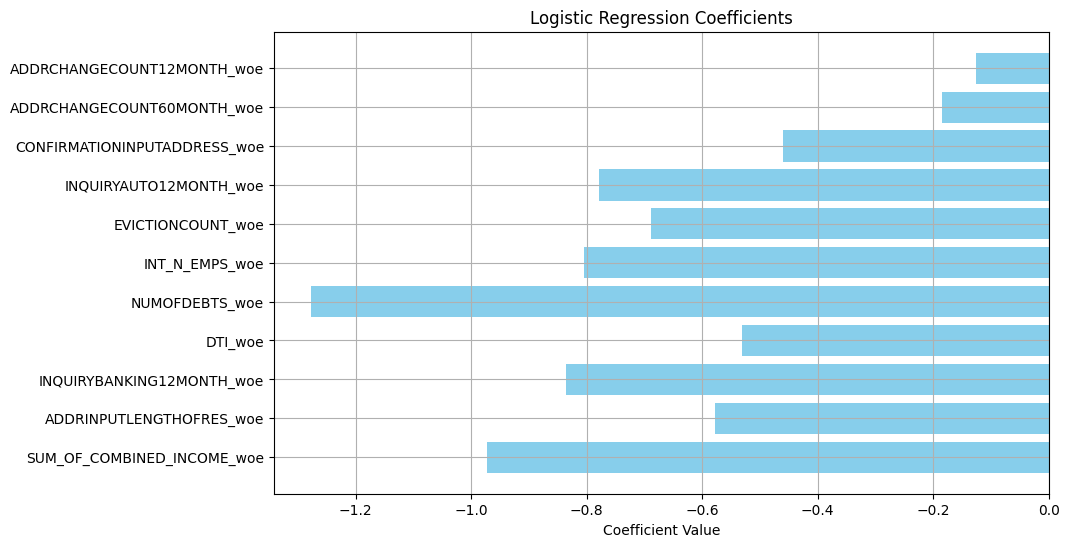

In [31]:
# 1. After RFA, use final set of selected features
final_selected_features = selected_features 

# 2. Prepare data with final selected features
X_train_selected = X_train[final_selected_features]
X_test_selected = X_test[final_selected_features]

# 3. Fit log. regression model using final selected features
# model = LogisticRegression(max_iter=1000)
model = LogisticRegression(max_iter=1000, random_state=42) # solver='liblinear', penalty='l2', C=0.1, class_weight='balanced', 
model.fit(X_train_selected, y_train)

# 4. Get coefficients for the final model
coefficients = model.coef_[0]  # Coeffs for all final features
feature_names = final_selected_features  # Get feature names used in model

# 5. Ensure # of coeffs and feature names match
if len(coefficients) != len(feature_names):
    print(f"Mismatch between the number of coefficients ({len(coefficients)}) and feature names ({len(feature_names)})")
    # Debugging: Print feature names and coefficients in case of mismatch in length
    print("Feature names:", feature_names)
    print("Coefficients:", coefficients)
else:
    # 6. Print coefficients and visual
    print("Model Coefficients:")
    for feature, coef in zip(feature_names, coefficients):
        print(f"{feature}: {coef:.4f}")
    
    # 7. Visualize coeffs in bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, coefficients, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title('Logistic Regression Coefficients')
    plt.grid(True)
    plt.show()


### ROC/AUC curve plotted

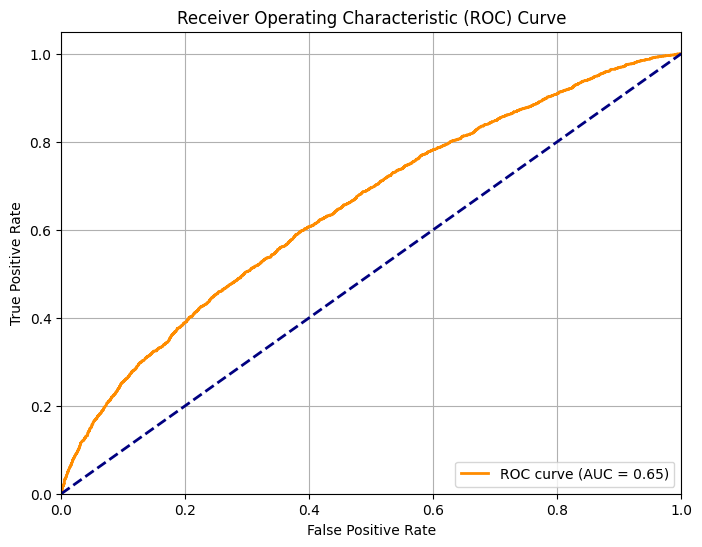

AUC: 0.6486


In [32]:
# Get model predictions (probabilities)
y_pred_prob = model.predict_proba(X_test_selected)[:, 1]  # Probability of the positive class

# Compute AUC directly using roc_auc_score
roc_auc_value = roc_auc_score(y_test, y_pred_prob)  # Calculate AUC

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC value
print(f"AUC: {roc_auc_value:.4f}")


### Confusion matrix plotted

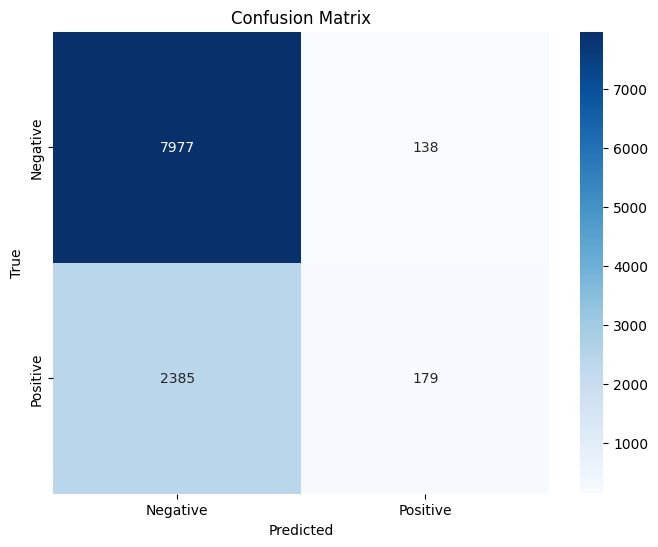

In [33]:
# Get model predictions (binary classification)
y_pred = model.predict(X_test_selected)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Precision recall plotted

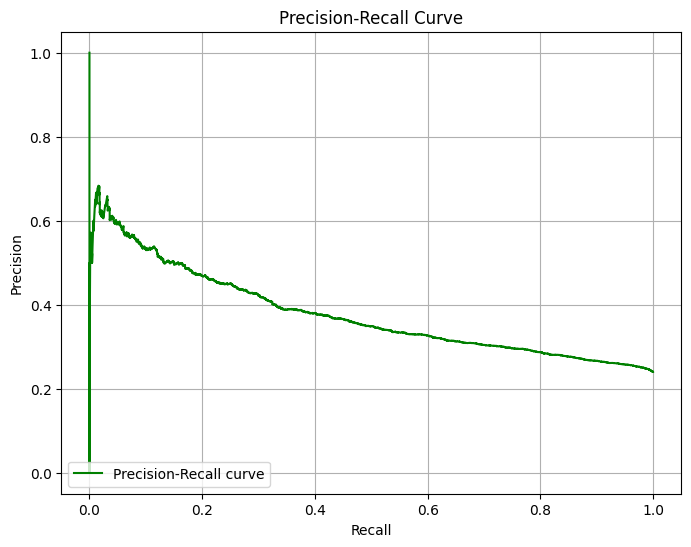

In [34]:
# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot precision recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Learning curve plotted

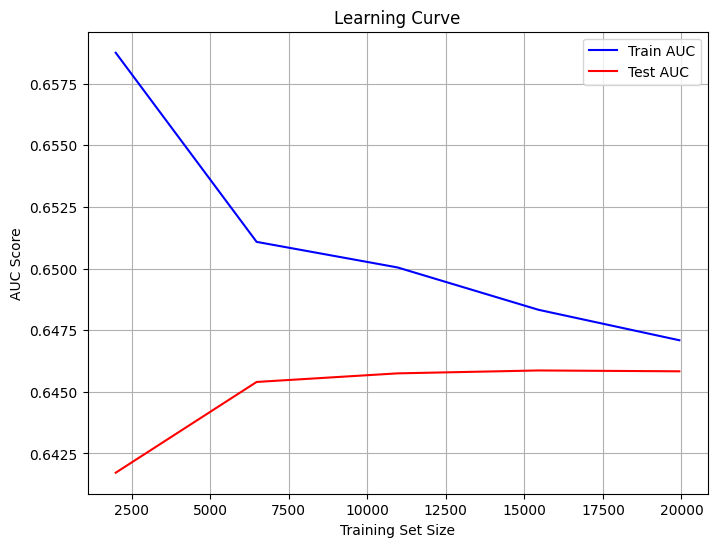

In [35]:
# Get learning curves
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000), X_train_selected, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), color='blue', label='Train AUC')
plt.plot(train_sizes, test_scores.mean(axis=1), color='red', label='Test AUC')
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()
